# A Demonstration of Python's Power

Here's just a quick demonstration of how to accomplish a pretty interesting task, computing and plotting [**Oceanic Niño Index**](https://www.ncdc.noaa.gov/teleconnections/enso/indicators/sst/), in Python. We won't explain much of what's going on here, but just want to show how much you can accomplish in Python.

First we just bring in some tools from a variety of Python libraries, using the import command. Python is really powerful at assembling various tools together like lego bricks.


## A whole bunch of imports

In [1]:
%matplotlib inline
import warnings
warnings.simplefilter("ignore") # Silence warnings
import xarray as xr
import numpy as np
from matplotlib import pyplot as plt

## Read sea surface temperature data

In [2]:
ds = xr.open_dataset("./data/NOAA_NCDC_ERSST_v3b_SST.nc")
ds

<xarray.Dataset>
Dimensions:  (lat: 89, lon: 180, time: 684)
Coordinates:
  * lat      (lat) float32 -88.0 -86.0 -84.0 -82.0 -80.0 ... 82.0 84.0 86.0 88.0
  * lon      (lon) float32 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0
  * time     (time) datetime64[ns] 1960-01-15 1960-02-15 ... 2016-12-15
Data variables:
    sst      (time, lat, lon) float32 ...
Attributes:
    Conventions:  IRIDL
    source:       https://iridl.ldeo.columbia.edu/SOURCES/.NOAA/.NCDC/.ERSST/...
    history:      extracted and cleaned by Ryan Abernathey for Research Compu...

In [3]:
sst = ds.sst

## Plot mean `sst` along `time` dimension

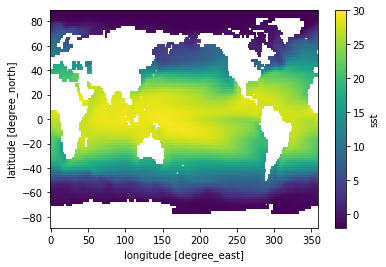

In [4]:
sst.mean(dim='time').plot(vmin=-2, vmax=30)

## Plot mean `sst` along `time` and `longitude` dimensions

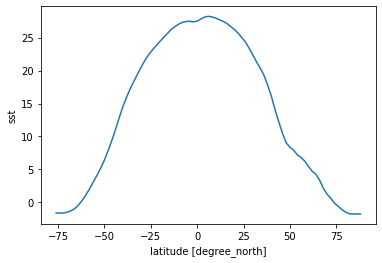

In [5]:
sst.mean(dim=('time', 'lon')).plot()

## Compute Zonal Anomaly

In [6]:
sst_zonal_time_mean = sst.mean(dim=('time', 'lon'))

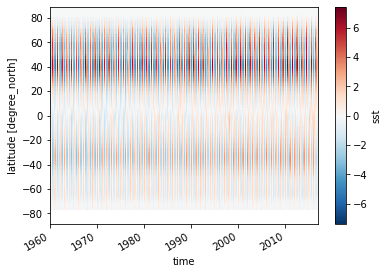

In [7]:
(sst.mean(dim='lon') - sst_zonal_time_mean).T.plot()

## Plot Data at a specific grid point

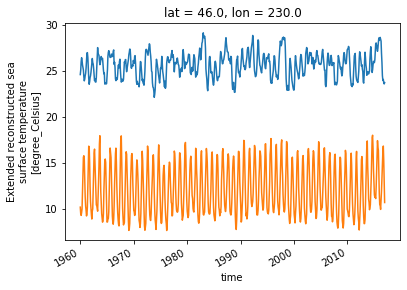

In [8]:
sst.sel(lon=230, lat=0, method='nearest').plot()
sst.sel(lon=230, lat=45, method='nearest').plot()

## Compute Climatologies

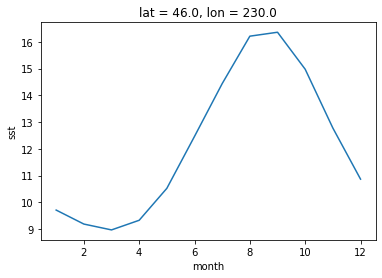

In [9]:
sst_clim = sst.groupby('time.month').mean(dim='time')
sst_clim.sel(lon=230, lat=45, method='nearest').plot()


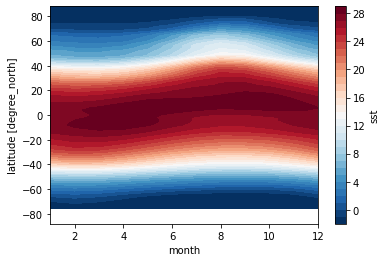

In [10]:
sst_clim.mean(dim='lon').T.plot.contourf(levels=np.arange(-2,30))

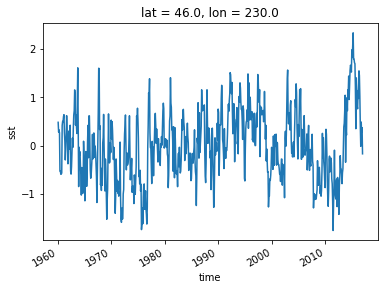

In [11]:
sst_anom = sst.groupby('time.month') - sst_clim
sst_anom.sel(lon=230, lat=45, method='nearest').plot()

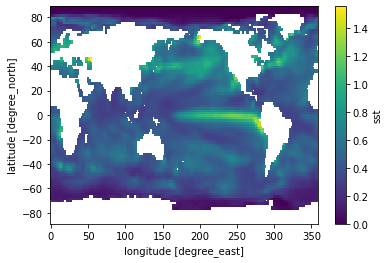

In [12]:
sst_anom.std(dim='time').plot()

## Compute El Niño (La Niña) Index 



https://www.ncdc.noaa.gov/teleconnections/enso/indicators/sst.php

El Niño (La Niña) is a phenomenon in the equatorial Pacific Ocean characterized by a five consecutive 3-month running mean of sea surface temperature (SST) anomalies in the Niño 3.4 region that is above (below) the threshold of +0.5°C (-0.5°C). This standard of measure is known as the Oceanic Niño Index (ONI).

![nino-regions](nino-regions.gif)

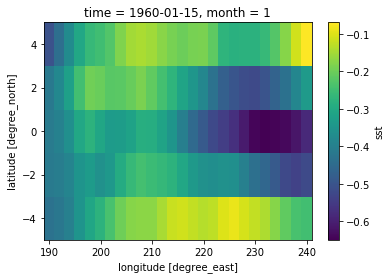

In [13]:
sst_anom_nino34 = sst_anom.sel(lat=slice(-5, 5), lon=slice(190, 240))
sst_anom_nino34[0].plot()

In [14]:
sst_anom_nino34_mean = sst_anom_nino34.mean(dim=('lon', 'lat'))
oni = sst_anom_nino34_mean.rolling(time=3).mean(dim='time')

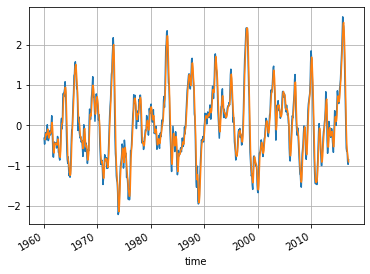

In [15]:
fig, ax = plt.subplots()
sst_anom_nino34_mean.plot(ax=ax, label='raw')
oni.plot(ax=ax, label='smoothed')
ax.grid()

![](eln-f-pg.gif)

In [16]:
# create a categorical  dataarray
nino34 = xr.full_like(oni, 'none', dtype='U4')
nino34[oni >= 0.5] = 'nino'
nino34[oni <= -0.5] = 'nina'
nino34


<xarray.DataArray (time: 684)>
array(['none', 'none', 'none', ..., 'nina', 'nina', 'nina'], dtype='<U4')
Coordinates:
  * time     (time) datetime64[ns] 1960-01-15 1960-02-15 ... 2016-12-15
    month    (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 2 3 4 5 6 7 8 9 10 11 12

In [17]:
sst_nino_composite = sst_anom.groupby(nino34.rename('nino34')).mean(dim='time')

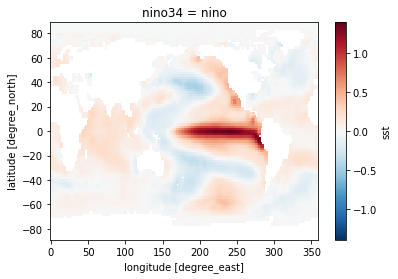

In [18]:
sst_nino_composite.sel(nino34='nino').plot()

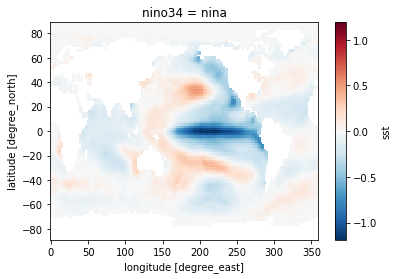

In [19]:
sst_nino_composite.sel(nino34='nina').plot()

In [20]:
nino_ds = xr.Dataset({'nino34': nino34, 'oni': oni}).drop('month')
nino_ds.to_netcdf('./data/nino34_index.nc')